In [1]:
import qctoolkit as qtk # https://github.com/SamKChang/qctoolkit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import glob
import os
import ast
import seaborn as sns

qtk.setting.quiet = True
sns.set()

%matplotlib inline

In [2]:
# ccs instance that defines the compound space
mol_base = qtk.Molecule('xyz/gaas_2.xyz')
mol_base.extend([3,3,3], normalize=True)
ccs = qtk.CCS(mol_base, 'ccs.yml')
# optimization log
log01 = qtk.Logger('optimization/algaas_333_01.db')
log02 = qtk.Logger('optimization/algaas_333_02.db')
log03 = qtk.Logger('optimization/algaas_333_03.db')
log04 = qtk.Logger('optimization/algaas_333_04.db')

# Sanity checks on radial distribution function

To make sure radial distribution function is bug free, detail checks is done on small systems where the actual atom pair distance can be counted by hand. All checks below give correct results and therefore there is no clue for bugs in $g(r)$ calculations.

## 211 fcc supercell 
**2 Ga and 2 As**

Conventionally, $g_{\rm GaAs}(r)$ is radially normalized, meaning 
$$
g_{\rm GaAs}(r) = \frac{N_{\rm GaAs}(r)}{4\pi r^2},
$$
where $N_{\rm GaAs}(r)$ is the number of Ga-As pair as distance $r$. 
The method **gr** takes a flag **radial_normalization** to return either $g(r)$ or $N(r)$ depending on selected atom types.

N(r): [ 3.  1.] , r: [ 2.4475  6.1625]


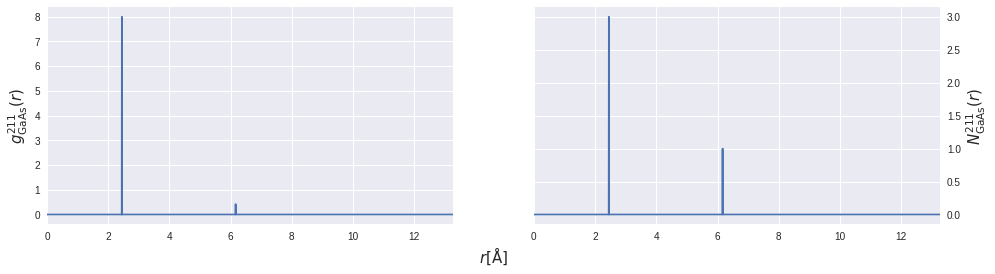

In [3]:
def basic_check():
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_211 = mol_base.copy()
    mol_211.extend([2,1,1], normalize=True)
    
    r, g = mol_211.gr('Ga', 'As', radial_normalization=True)
    r, N = mol_211.gr('Ga', 'As', radial_normalization=False)
    
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(16,4))
    ax1.plot(r, g)
    ax1.set_xlim(r.min(), r.max())
    ax1.set_xlabel(r'$r [{\rm \AA}]$',x=1.1, fontsize=15)
    ax1.set_ylabel(r'$g_{\rm GaAs}^{211}(r)$', fontsize=15)
    ax2.plot(r, N)
    print "N(r):", N[N>0], ", r:", r[N>0]
    ax2.set_xlim(r.min(),r.max())
    ax2.set_ylabel(r'$N_{\rm GaAs}^{211}(r)$', fontsize=15)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    pass

basic_check()

$N_{\rm GaAs}^{211}(r)$ correctly gives 3 Ga-As pair at 2.4 angstrom and 1 Ga-As pair at 6.1 angstrom.

## 311, 221, 222 fcc supercells

311
N(r): [ 5.  3.  1.]
r: [  2.4475   6.1625  10.0925]

221
N(r): [ 8.  3.  4.  1.]
r: [ 2.4475  4.6875  6.1625  9.2675]

222
N(r): [ 20.  21.  12.   4.   6.   1.]
r: [  2.4475   4.6875   6.1625   7.3425   9.2675  12.2425]



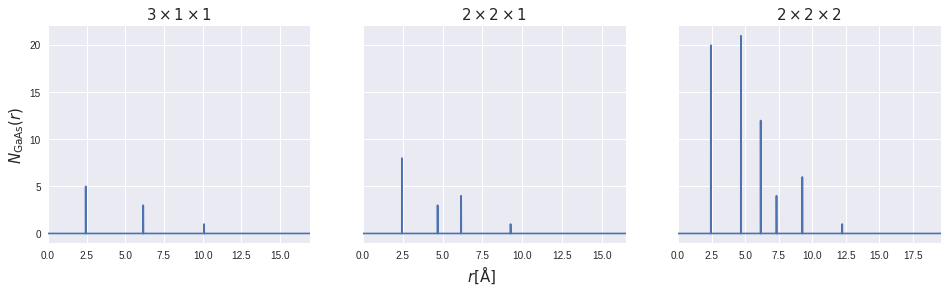

In [4]:
def cell_check():
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_311 = mol_base.copy()
    mol_311.extend([3,1,1], normalize=True)
    mol_311.symmetry=False
    mol_311.write('test_311.xyz')

    mol_221 = mol_base.copy()
    mol_221.extend([2,2,1], normalize=True)
    mol_221.symmetry=False
    mol_221.write('test_221.xyz')

    mol_222 = mol_base.copy()
    mol_222.extend([2,2,2], normalize=True)
    mol_222.symmetry=False
    mol_222.write('test_222.xyz')

    mols = [mol_311, mol_221, mol_222]
    names = [r'$3\times 1\times1$', r'$2\times 2\times 1$', r'$2\times 2\times 2$']
    systems = ['311', '221', '222']

    fig, axs = plt.subplots(1, 3, figsize=(16,4), sharey=True)

    for i in range(3):
        mol = mols[i]
        ax = axs[i]
        r, N = mol.gr('Ga', 'As', radial_normalization=False)
        print systems[i]
        print "N(r):", N[N>0]
        print "r:", r[N>0]
        print 
        ax.plot(r, N)
        ax.set_xlim(r.min(),r.max())
        ax.set_title(names[i], fontsize=15)
    axs[0].set_xlabel(r'$r [{\rm \AA}]$',x=1.65, fontsize=15)
    axs[0].set_ylabel(r'$N_{\rm GaAs}(r)$', fontsize=15)

cell_check()

Number of Ga-As pair counts at each distance are correct, note that the fcc primitive cell is not orthorhombic.

## 311 AlGaAs supercell
**4 fcc primitive cells with 1 Ga mutates to Al**

Ga-As
N(r): [ 4.  2.]
r: [ 2.4475  6.1625]

Al-As
N(r): [ 1.  1.  1.]
r: [  2.4475   6.1625  10.0925]

Al-Ga
N(r): [ 1.  1.]
r: [ 3.9975  7.9975]



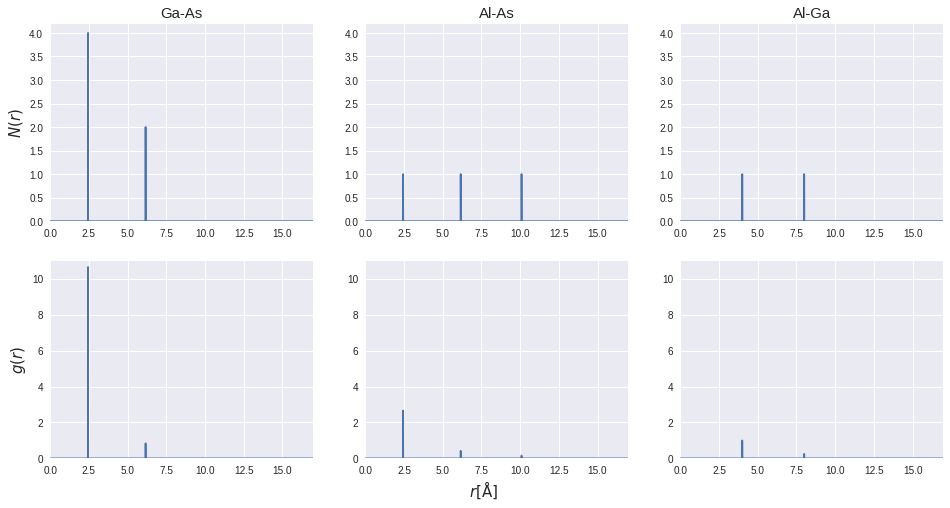

In [5]:
def plot_311_mixed():
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    algaas = mol_base.copy()
    algaas.extend([3,1,1], normalize=True)
    algaas.symmetry=False
    algaas.setAtoms(0, Z=13)
    algaas.write('test_algaas.xyz')

    r, N_gaas = algaas.gr('Ga', 'As', radial_normalization=False)
    r, N_alas = algaas.gr('Al', 'As', radial_normalization=False)
    r, N_alga = algaas.gr('Al', 'Ga', radial_normalization=False)
    r, g_gaas = algaas.gr('Ga', 'As', radial_normalization=True)
    r, g_alas = algaas.gr('Al', 'As', radial_normalization=True)
    r, g_alga = algaas.gr('Al', 'Ga', radial_normalization=True)
    N_all = [N_gaas, N_alas, N_alga]
    g_all = [g_gaas, g_alas, g_alga]
    titles = ['Ga-As', 'Al-As', 'Al-Ga']

    fig, [axs, axs_2] = plt.subplots(2, 3, figsize=(16,8))

    for i in range(3):
        ax = axs[i]
        ax2 = axs_2[i]
        N = N_all[i]
        g = g_all[i]
        print titles[i]
        print "N(r):", N[N>0]
        print "r:", r[N>0]
        print 
        ax.plot(r, N)
        ax.set_xlim(r.min(),r.max())
        ax.set_title(titles[i], fontsize=15)
        ax.set_ylim(0,4.2)
        ax2.set_ylim(0,11)
        ax2.plot(r, g)
        ax2.set_xlim(r.min(),r.max())
    axs[0].set_ylabel(r'$N(r)$', fontsize=15)
    axs_2[0].set_xlabel(r'$r [{\rm \AA}]$',x=1.65, fontsize=15)
    axs_2[0].set_ylabel(r'$g(r)$', fontsize=15)

plot_311_mixed()

It can be easily verified that $N_{\rm GaAs}^{\rm AlGaAs}(r) + N_{\rm AlAs}^{\rm AlGaAs}(r) = N_{\rm GaAs}^{\rm GaAs}(r)$, where the nearest, second nearset, and the third nearest distance counts are

$$
\begin{array}{lcl}
N_{\rm GaAs}^{\rm AlGaAs}(r) &=& (4, 2, 0)\\
N_{\rm AlAs}^{\rm AlGaAs}(r) &=& (1, 1, 1)\\
N_{\rm GaAs}^{\rm GaAs}(r) &=& (5, 3, 1)
\end{array}
$$

## Analysis on optimized a crystal 
**$3\times 3\times 3$ supercell with 27 III-sites (Ga or Al) and 27 As**

In [6]:
def opt_rdf_test(radial_normalization=False):

    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)

    # extract best molecules from optimization
    mols = []

    N_mol = 3

    for entry in log01.list(order='descent')[:N_mol]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mols.append(ccs.generate(**ccs_coord))


    mol_name = ['Best crystal', 'Second best crystal', 'Third best crystal']
    
    fig, axarr = plt.subplots(N_mol, 4, figsize=(16, 4*N_mol), sharex=True, sharey=True)
    r, y_base = mol_base.gr('Ga', 'As', radial_normalization=radial_normalization)
    if radial_normalization:
        y_name = 'g'
    else:
        y_name = 'N'
    
    for i in range(N_mol):

        mol = mols[i]

        r, y_GaAs = mol.gr('Ga', 'As', radial_normalization=radial_normalization)
        r, y_AlAs = mol.gr('Al', 'As', radial_normalization=radial_normalization)
        y_diff = y_GaAs + y_AlAs - y_base
        y_diff[np.abs(y_diff) < 1E-5] = 0
        y_all = [y_GaAs + y_AlAs, y_GaAs, y_AlAs, y_diff]

        for j in range(4):
            ax = axarr[i, j]
            y = y_all[j]
            ax.plot(r, y)
            ax.set_xlim(2, 20)
            
            if j == 0:
                y_min, y_max = ax.get_ylim()
            else:
                ax.set_ylim(y_min, y_max)
            
            if j == 3:
                try:
                    ax.set_ylabel(mol_name[i], fontsize=15)
                    ax.yaxis.set_label_position('right')
                except:
                    pass

    axarr[N_mol-1,0].set_xlabel(r'$r [\rm \AA]$', x=2.3, fontsize=15)
    axarr[N_mol-1,0].set_ylabel(r'$%s(r)$' % y_name, y=1.65, fontsize=15)
    axarr[0, 0].set_title(r'${}_{{\rm GaAs}}(r)+{}_{{\rm AlAs}}(r)$'.format(y_name, y_name), fontsize=15)
    axarr[0, 1].set_title(r'${}_{{\rm GaAs}}(r)$'.format(y_name), fontsize=15)
    axarr[0, 2].set_title(r'${}_{{\rm AlAs}}(r)$'.format(y_name), fontsize=15)
    axarr[0, 3].set_title(
        r'${}_{{\rm GaAs}}(r)+{}_{{\rm AlAs}}(r)-{}_{{\rm GaAs}}^{{\rm ref}}(r)$'.format(
            y_name, y_name, y_name
        ), 
        fontsize=15
    )
    return fig

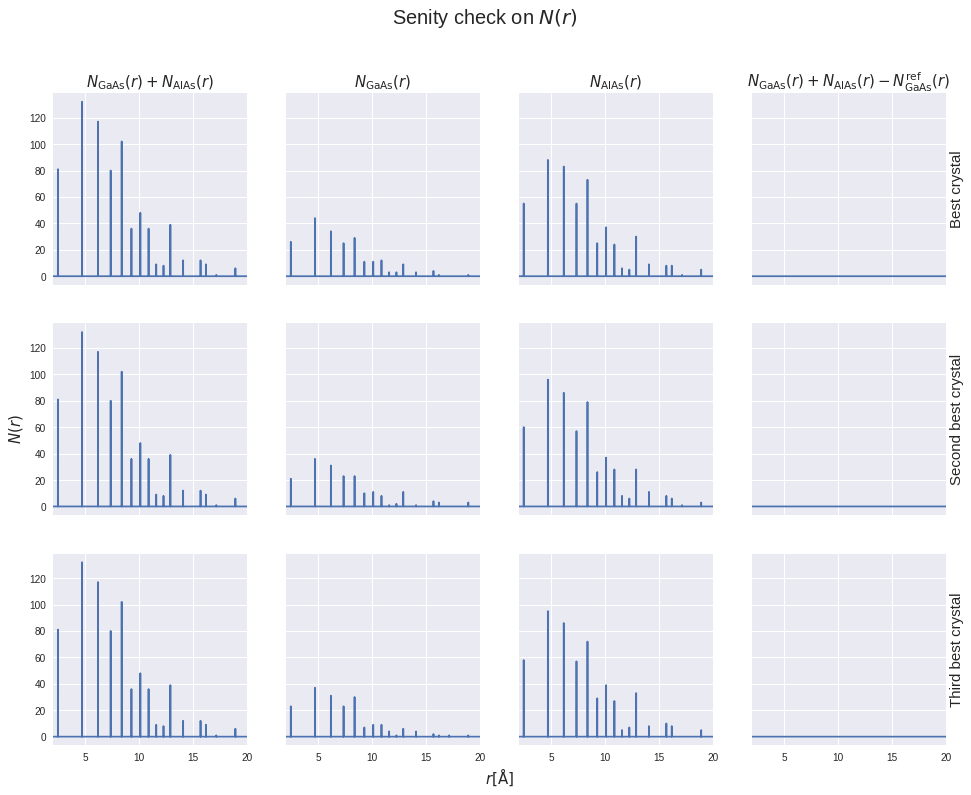

In [7]:
opt_rdf_test()
plt.suptitle(r'Senity check on $N(r)$', fontsize=20)
pass

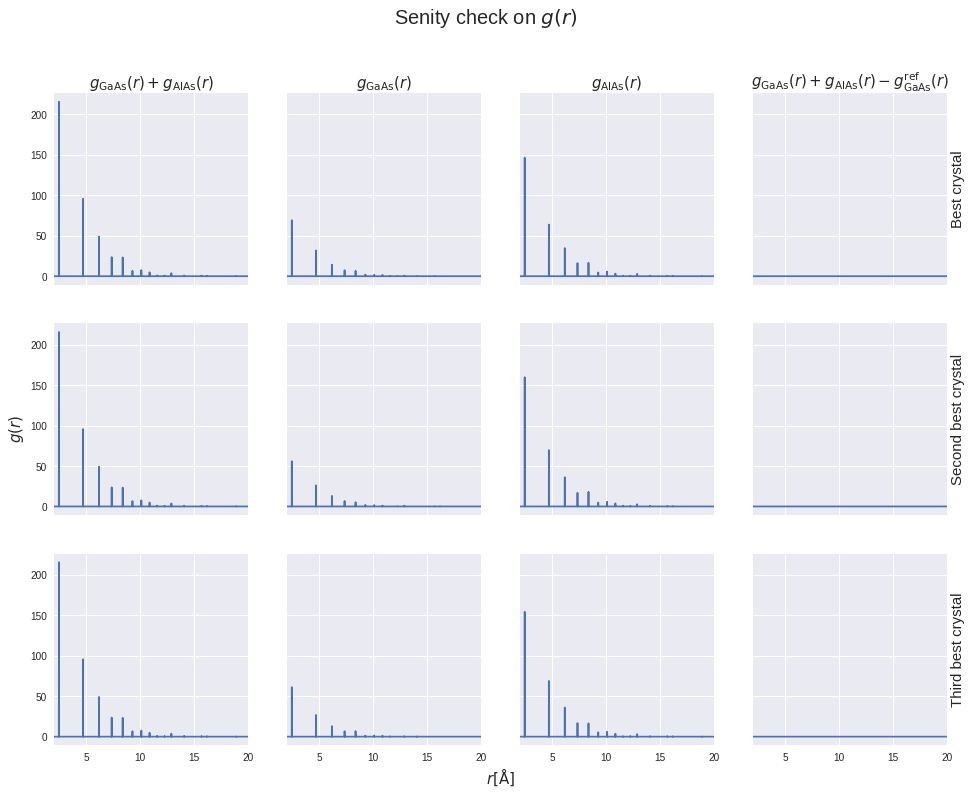

In [8]:
opt_rdf_test(True)
plt.suptitle(r'Senity check on $g(r)$', fontsize=20)
pass

# Structual analysis on optimized crystals

Having thoroughly tested the code for **g(r)** calculation, I am confident the results is bug free. Since it is easier to understand $N(r)$ than $g(r)$, the analysis below will focus only on $N(r)$ for various cases. The goal is to extract some features in $N(r)$ of the best crystals, which could be used as an indicator of the band gap.

## $N_{\rm AlAs}(r)$ for the best crystals

As shown above, $N_{\rm AlAs}(r) + N_{\rm GaAs}(r) = N_{\rm GaAs}^{\rm ref}(r)$, I only need to focus on $N_{\rm AlAs}(r)$. In order to show the structrual variations, it is compared with scaled $N_{\rm GaAs}^{\rm ref}(r)$. That is I am looking at the quantity

$$
\Delta N_{\rm AlAs}(r) = N_{\rm AlAs}(r) - x N_{\rm GaAs}^{\rm ref}(r),
$$

or

$$
\Delta N_{\rm GaAs}(r) = N_{\rm GaAs}(r) - (1-x) N_{\rm GaAs}^{\rm ref}(r),
$$

where $x$ is the mole fraction of Al in the optimized Al$_x$Ga$_{1-x}$As crystals. Note that 

$$
\Delta N_{\rm AlAs}(r) + \Delta N_{\rm GaAs}(r) = N_{\rm AlAs}(r) + N_{\rm GaAs}(r) - N_{\rm GaAs}^{\rm ref}(r) = 0
$$

In [9]:
def dN_AlAs_test(N_mol, log, title_str=''):
    
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)
    
    r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)

    mols = []
    for entry in log.list(order='descent')[:N_mol**2]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mols.append(ccs.generate(**ccs_coord))

    dN_tops = []
    x_list = []
    for mol in mols:
        x = np.ones(mol.N)[np.abs(np.array(mol.Z) - 13) < 0.001].sum() / (mol.N / 2.)
        r, N = mol.gr('Al', 'As', radial_normalization=False)
        dN_tops.append(N - x*N_ref)
        x_list.append(x)

    dN_tops = np.vstack(dN_tops)

    fig, axarr = plt.subplots(N_mol, N_mol, figsize=(16, 12), sharex=True, sharey=True)

    for i in range(N_mol):
        for j in range(N_mol):
            k = j + i*N_mol
            ax = axarr[i, j]
            ax.plot(r, dN_tops[k])
            ax.set_title("rank: %d, x=%4.2f" % ((k+1), x_list[k]))
    axarr[0, 0].set_xlim(2, 20)
    axarr[N_mol-1, 0].set_xlabel(r'$r$ [${\rm \AA}$]', fontsize=15, x = float(N_mol)/2 + 0.35)
    axarr[N_mol-1, 0].set_ylabel(r'$\Delta N_{\rm AlAs}(r)$', fontsize=15, y = float(N_mol)/2 + 0.45)
    plt.suptitle(r'$\Delta N_{{\rm AlAs}}(r)$ of top {} cystals '.format(N_mol**2) + title_str, fontsize=20)
    pass

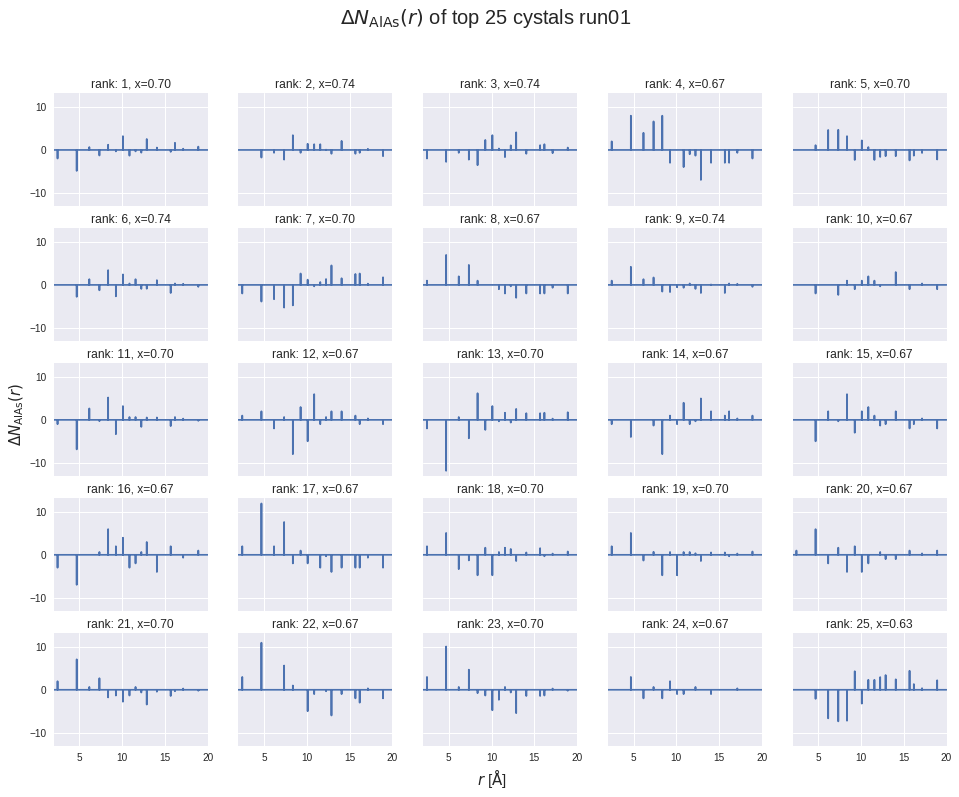

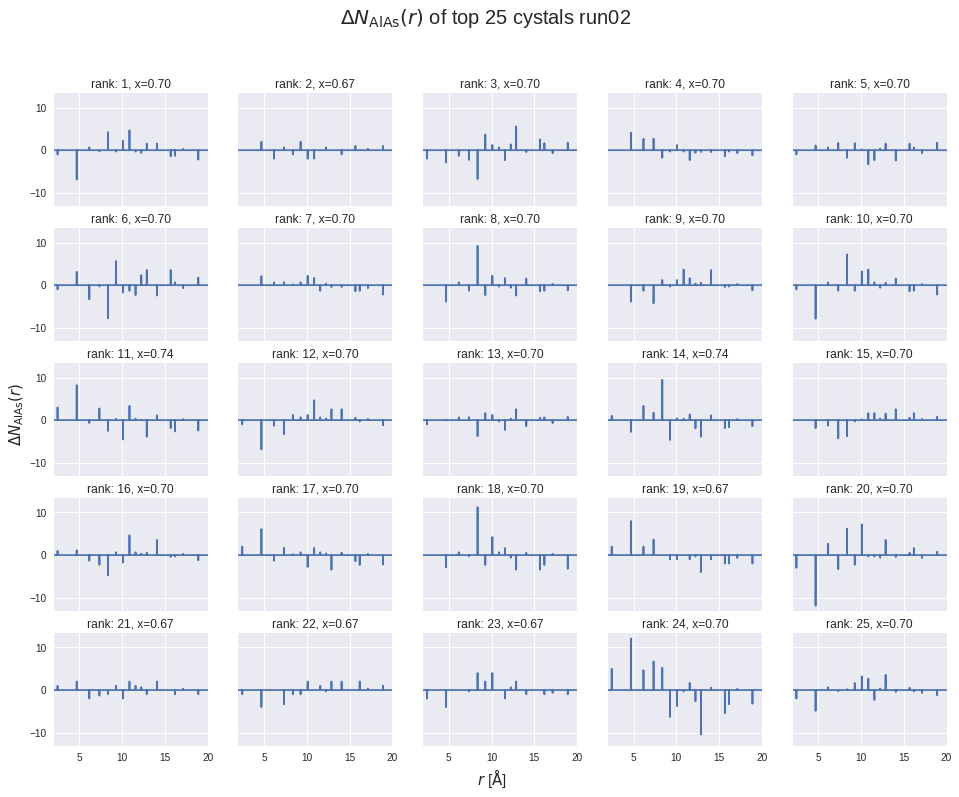

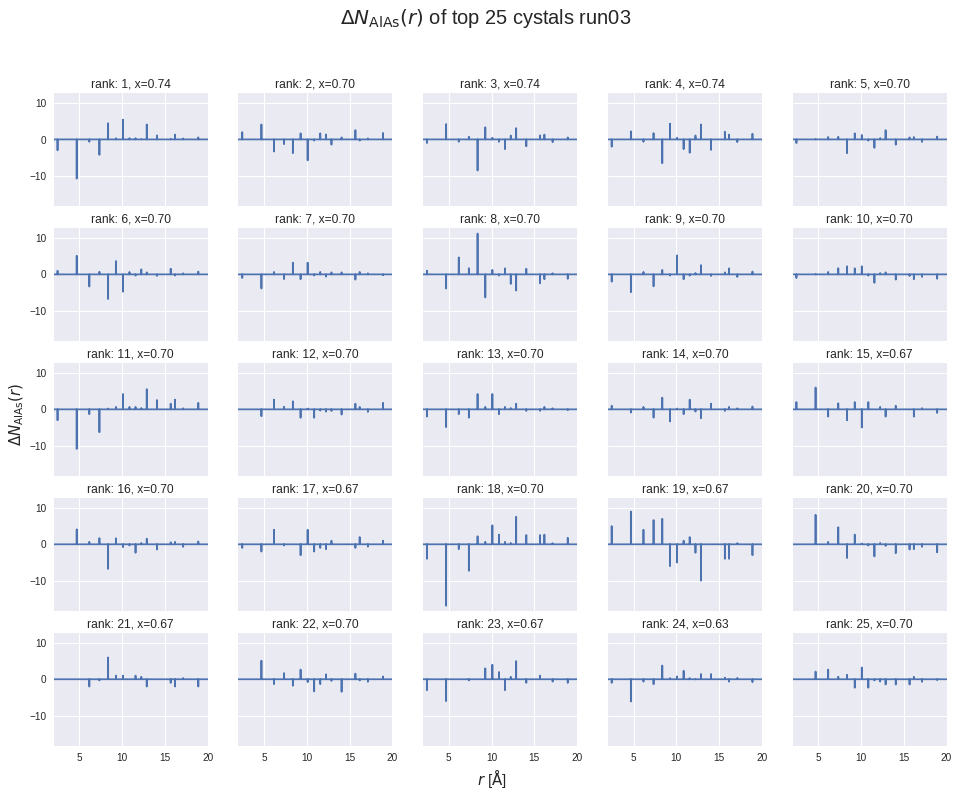

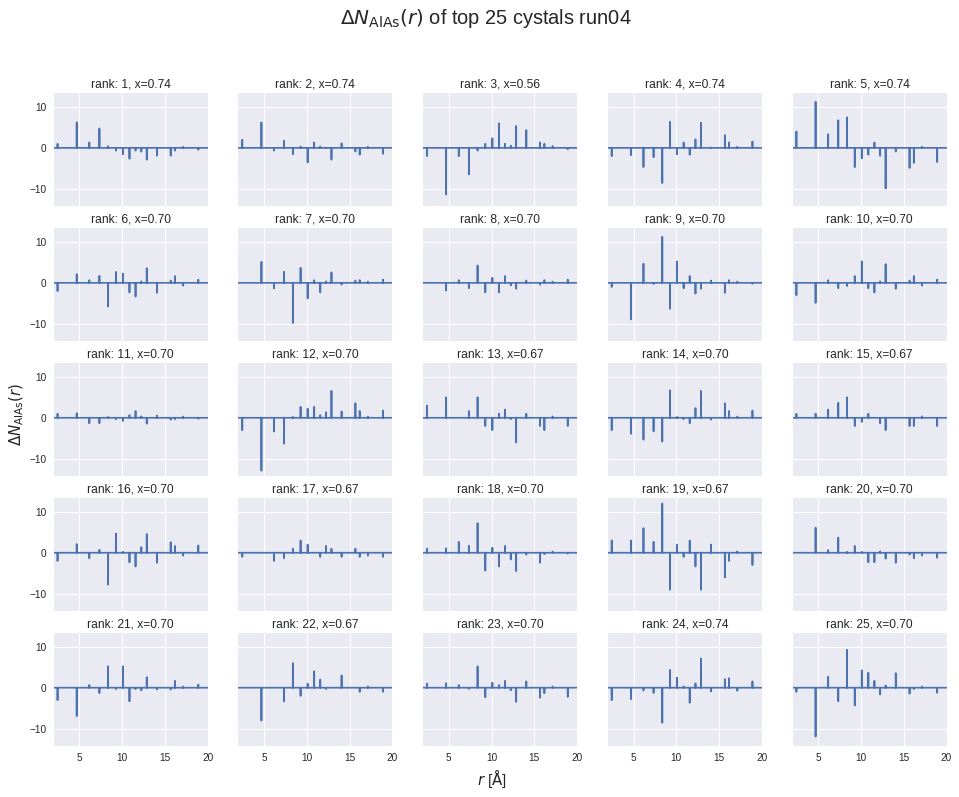

In [10]:
dN_AlAs_test(5, log01, 'run01')
dN_AlAs_test(5, log02, 'run02')
dN_AlAs_test(5, log03, 'run03')
dN_AlAs_test(5, log04, 'run04')

In [11]:
def dN_AlAs_average(N_mol, log):
    
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)
    
    r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    mols = []
    for entry in log.list(order='descent')[:N_mol**2]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mols.append(ccs.generate(**ccs_coord))
    
    dN_tops = []
    x_list = []
    for mol in mols:
        x = np.ones(mol.N)[np.abs(np.array(mol.Z) - 13) < 0.001].sum() / (mol.N / 2.)
        r, N = mol.gr('Al', 'As', radial_normalization=False)
        dN_tops.append(N - x*N_ref)
    dN_tops = np.vstack(dN_tops)

    dN_mean = dN_tops.mean(0)
    dN_err = dN_tops.std(0)

    ax.plot(r, N_ref, label=r'$N_{\rm GaAs}^{\rm ref}(r)$', zorder=10)

    (_, caps, _) = ax.errorbar(
        r[N_ref>0], dN_mean[N_ref>0],
        yerr=[dN_err[N_ref > 0], dN_err[N_ref > 0]],
        ls='',
        capsize=7,
        fmt='o',
        color='orange',
        label=r'$\overline{\Delta N}_{\rm AlAs}(r)$',
        zorder=11
    )
    for cap in caps:
        cap.set_markeredgewidth(1)
    ax.plot(r[N_ref > 0], dN_tops[0][N_ref > 0], 
        ls='', marker='s', color='forestgreen',zorder=12, label=r'$\Delta N_{\rm AlAs}^{\rm best}(r)$'
    )
    ax.set_title(r"Averaged $\Delta N_{{\rm AlAs}}(r)$ over top {} crystals".format(N_mol), fontsize=20)
    ax.set_ylabel(r'$\overline{\Delta N}_{\rm AlAs}(r)$', fontsize=15)
    ax.set_xlabel(r'$r$ [${\rm \AA}$]', fontsize=15)
    ax.set_xlim(2, 20)

    ax.legend(fontsize=15)
    pass

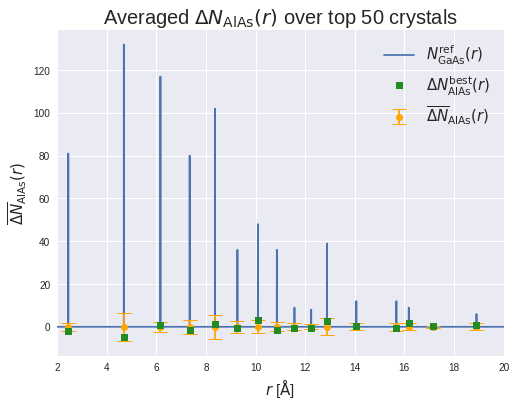

In [12]:
dN_AlAs_average(50, log01)

It turned out that there is no obvious general feature of $\Delta N_{\rm AlAs}(r)$ among the best crystals. The next attempt is to find the clusters of $N_{\rm AlAs}(r)$ among the best crystals.

## $N_{\rm AlAs}(r)$ clusters
** The analysis is done by SVD and transformed to PCA **

In [13]:
r, N_ref = mol_base.gr('Ga', 'As', radial_normalization=False)

def get_dN(N_mol, log):
    
    mol_base = qtk.Molecule('xyz/gaas_2.xyz')
    mol_base.extend([3,3,3], normalize=True)
    
    N_list = []
    for entry in log.list(order='descent')[:N_mol]:
        # extract dictionary of mutation location
        ccs_coord = ast.literal_eval(entry.content)
        # generate molecule object using ccs coordinate and ccs instance
        mol = ccs.generate(**ccs_coord)
        x = np.ones(mol.N)[np.abs(np.array(mol.Z) - 13) < 0.001].sum() / (mol.N / 2.)
        r, N = mol.gr('Al', 'As', radial_normalization=False)
        N_list.append(N - x*N_ref)
    return np.vstack(N_list)

def svd(N):
    U, d, Vt = np.linalg.svd(N)
    V = Vt.T
    return U, d, V

In [14]:
N1 = get_dN(15, log01)
N2 = get_dN(15, log02)
N3 = get_dN(15, log03)
N4 = get_dN(15, log04)

In [15]:
N_all = np.vstack([N1, N2, N3, N4])
U, d, V = svd(N_all)

In [16]:
U1, d1, V1 = svd(N1)
U2, d2, V2 = svd(N2)
U3, d3, V3 = svd(N3)
U4, d4, V4 = svd(N4)

In [17]:
U_all = [U1, U2, U3, U4]
d_all = [d1, d2, d3, d4]
V_all = [V1, V2, V3, V4]

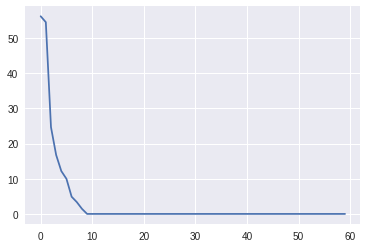

In [18]:
plt.plot(d)

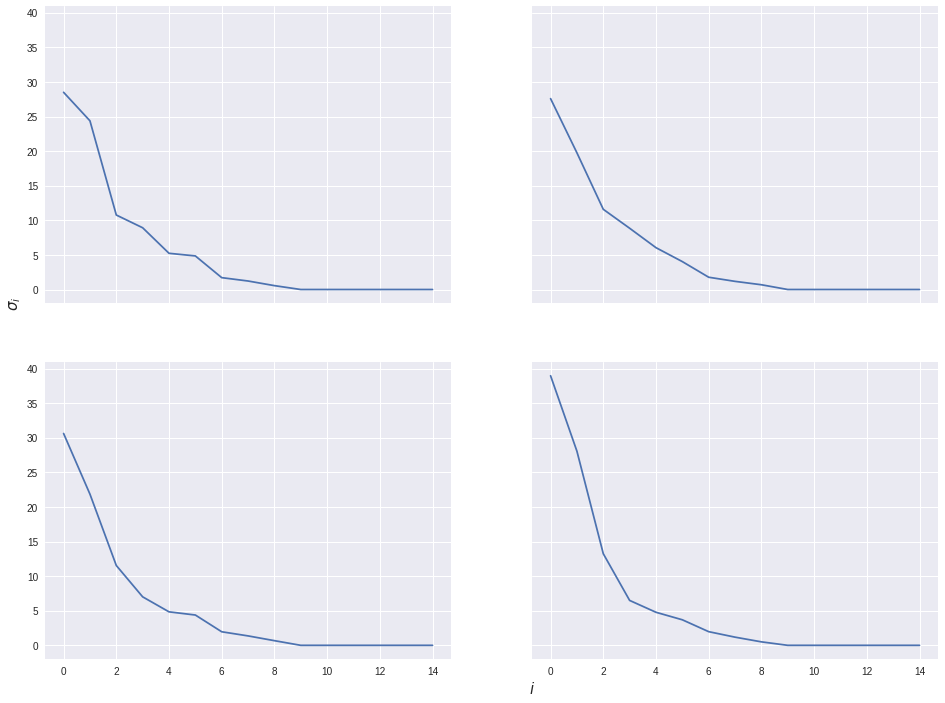

In [19]:
fig, axarr = plt.subplots(2, 2, figsize=(16,12), sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        ind = i*2 + j
        axarr[i, j].plot(d_all[ind])
axarr[1, 0].set_xlabel(r'$i$', fontsize=15, x = 1.2)
axarr[1, 0].set_ylabel(r'$\sigma_i$', fontsize=15, y = 1.2)

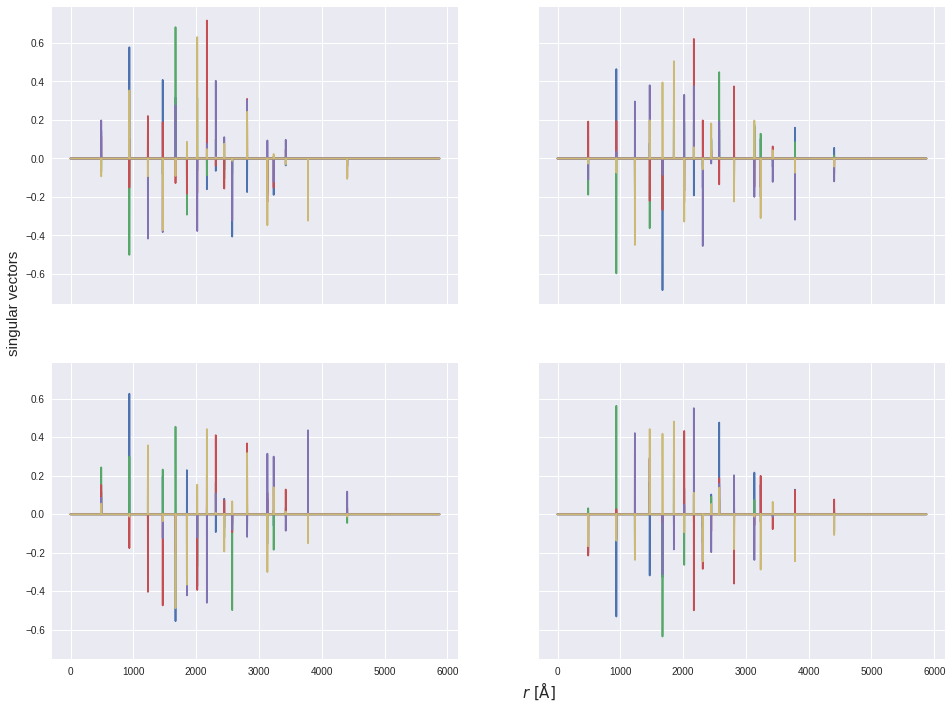

In [20]:
fig, axarr = plt.subplots(2, 2, figsize=(16,12), sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        ind = i*2 + j
        for k in range(5):
            axarr[i, j].plot(V_all[ind][:,k])
axarr[1, 0].set_xlabel(r'$r\ [\rm \AA]$', fontsize=15, x = 1.2)
axarr[1, 0].set_ylabel(r'singular vectors', fontsize=15, y = 1.2)

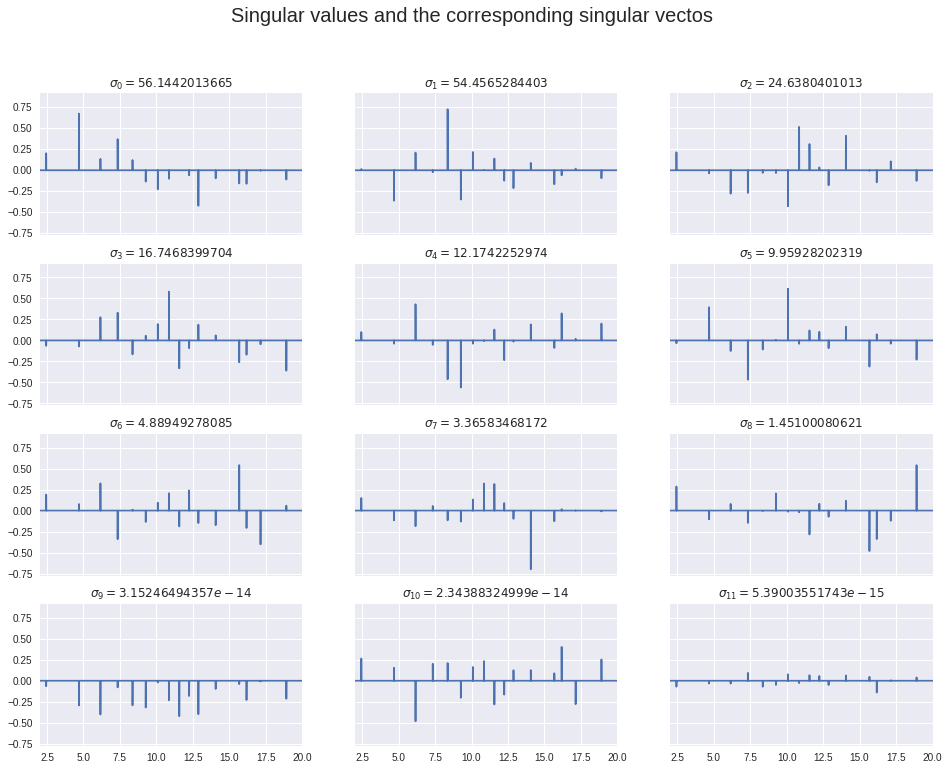

In [21]:
Ni = 4
Nj = 3

fig, axarr = plt.subplots(Ni, Nj, figsize=(16,12), sharex=True, sharey=True)
for i in range(Ni):
    for j in range(Nj):
        ind = i*Nj + j
        axarr[i, j].plot(r, V[:,ind])
        axarr[i, j].set_title(r"$\sigma_{{{}}}={}$".format(ind, d[ind]))
axarr[0, 0].set_xlim(2, 20)
plt.suptitle("Singular values and the corresponding singular vectos", fontsize=20)

In [25]:
# principal components to 
pc = U.dot(np.diag(d))

# sanity checks for principal components
print abs(pc.dot(V[:, :len(d)].T) - N_all).sum()

4.67606263947e-12
